In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier, plot_tree
import os


PRIMERAMENTE VAMOS A CARGAR TODOS LOS ARCHIVOS Y A RELACIONAR LAS TABLAS USANDO LAS PRIMARY KEY


CREAMOS EL TARGET

VAMOS A JUNTAR LAS TABLAS MEDIANTE LAS PRIMARY KEY

In [6]:
from pathlib import Path
from functools import reduce
import pandas as pd

base = Path.cwd()
data_dir = base if (base / "data").exists() else base.parent  

dfs = {
    "orders": pd.read_csv(data_dir / "data" / "crudo" / "olist_orders_dataset.csv"),
    "order_items": pd.read_csv(data_dir / "data" / "crudo" / "olist_order_items_dataset.csv"),
    "products": pd.read_csv(data_dir / "data" / "crudo" / "olist_products_dataset.csv"),
    "sellers": pd.read_csv(data_dir / "data" / "crudo" / "olist_sellers_dataset.csv"),
    "customers": pd.read_csv(data_dir / "data" / "crudo" / "olist_customers_dataset.csv"),
    "payments": pd.read_csv(data_dir / "data" / "crudo" / "olist_order_payments_dataset.csv"),
    "reviews": pd.read_csv(data_dir / "data" / "crudo" / "olist_order_reviews_dataset.csv"),
}

joins = [
    ("orders", "order_items", "order_id"),
    ("orders", "payments", "order_id"),
    ("orders", "reviews", "order_id"),
    ("order_items", "products", "product_id"),
    ("order_items", "sellers", "seller_id"),
    ("orders", "customers", "customer_id"),
]

final_dataset = reduce(
    lambda left, relation: pd.merge(
        left,
        dfs[relation[1]],        # nombre del dataframe de la derecha
        on=relation[2],          # columna de unión
        how="left",
        suffixes=("", f"_{relation[1]}")
    ),
    joins,
    dfs["orders"]
)



preview = final_dataset.head(3)
preview



,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,9350.0,maua,SP,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,9350.0,maua,SP,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,9350.0,maua,SP,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP


AÑADIMOS EL TARGET

In [7]:
fecha_cols = [
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
]

final_dataset[fecha_cols] = final_dataset[fecha_cols].apply(
    pd.to_datetime, errors="coerce"
)

final_dataset["late_delivery"] = (
    final_dataset["order_delivered_customer_date"]
    > final_dataset["order_estimated_delivery_date"]
).fillna(False).astype(int)


In [8]:
final_dataset.to_csv("data/procesado/olist_interest_complete.csv", index=False)

##AHORA QUE TENEMOS UN ÚNICO DATAFRAME VAMOS A MIRAR UNA DESCRIPCION DE LAS VARIABLES   

In [9]:
final_dataset.describe(include='all')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,late_delivery
count,119143,119143,119143,119143,118966,117057,115722,119143,118310.000000,118310,...,118290.000000,118290.000000,118310.000000,118310,118310,119143,119143.000000,119143,119143,119143.000000
unique,99441,99441,8,98875,90733,81018,NaN,NaN,NaN,32951,...,NaN,NaN,NaN,611,23,96096,NaN,4119,27,NaN
top,895ab968e7bb0d5659d16cd74cd1650c,270c23a11d024a44c896d1894b261a83,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,NaN,NaN,NaN,aca2eb7d00ea1a7b8ebd4e68314663af,...,NaN,NaN,NaN,sao paulo,SP,9a736b248f67d166d2fbb006bcb877c3,NaN,sao paulo,SP,NaN
freq,63,63,115723,63,63,63,NaN,NaN,NaN,536,...,NaN,NaN,NaN,29293,84377,75,NaN,18875,50265,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-12 20:55:38.199616,2018-01-22 15:21:10.241642240,1.196543,NaN,...,16.619706,23.074799,24442.410413,NaN,NaN,NaN,35033.451298,NaN,NaN,0.076110
min,NaN,NaN,NaN,NaN,NaN,NaN,2016-10-11 13:46:32,2016-09-30 00:00:00,1.000000,NaN,...,2.000000,6.000000,1001.000000,NaN,NaN,NaN,1003.000000,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,2017-09-22 21:54:31.249999872,2017-10-02 00:00:00,1.000000,NaN,...,8.000000,15.000000,6429.000000,NaN,NaN,NaN,11250.000000,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,2018-02-01 03:17:55,2018-02-14 00:00:00,1.000000,NaN,...,13.000000,20.000000,13660.000000,NaN,NaN,NaN,24240.000000,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,2018-05-15 00:08:31.500000,2018-05-25 00:00:00,1.000000,NaN,...,20.000000,30.000000,27972.000000,NaN,NaN,NaN,58475.000000,NaN,NaN,0.000000
max,NaN,NaN,NaN,NaN,NaN,NaN,2018-10-17 13:22:46,2018-11-12 00:00:00,21.000000,NaN,...,105.000000,118.000000,99730.000000,NaN,NaN,NaN,99990.000000,NaN,NaN,1.000000


AHORA MIREMOS SI HAY VALORES NULOS 

In [10]:
# Revisar si hay valores nulos en las columnas clave
null_summary = final_dataset[[
    'order_id', 'late_delivery', 'product_id', 'product_category_name',
    'seller_id', 'seller_city', 'customer_id', 'customer_city',
    'payment_type', 'payment_value', 'review_score'
]].isnull().sum().sort_values(ascending=False)

null_summary = null_summary.to_frame(name="Valores nulos")
null_summary


##OBSERVAMOS QUE VARIAS DE NUESTRAS VARIABLES TIENEN VALORES NULOS.

,Valores nulos
product_category_name,2542
review_score,997
product_id,833
seller_id,833
seller_city,833
payment_type,3
payment_value,3
order_id,0
late_delivery,0
customer_id,0


MIREMOS TAMBIEN LA CANTIDAD DE OUTLIERS QUE PRESENTAN LAS VARIABLES NUMERICAS NO CATEGORICAS

In [15]:
%load_ext autoreload
%autoreload 2
import importlib, src.funciones as funciones  # noqa: E401
importlib.reload(funciones)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'src.funciones' from '/Users/gallego/proyectos/modelo_clasificacion/src/funciones.py'>

In [20]:
# Adaptar la función al DataFrame final que estás usando
def resumen_faltantes_outliers(df):
    col_numericas = [
        col for col in df.select_dtypes(include=['float64', 'int64']).columns
        if df[col].nunique(dropna=True) > 2
    ]

    lista_variables_numericas = []

    for col in col_numericas:
        n_total = df.shape[0]
        n_faltantes = df[col].isnull().sum()

        # Rango intercuartílico para outliers
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        limite_superior = q3 + 1.5 * iqr
        limite_inferior = q1 - 1.5 * iqr

        # Outliers
        n_outliers = df[(df[col] < limite_inferior) | (df[col] > limite_superior)].shape[0]

        lista_variables_numericas.append({
            'variable': col,
            'n_faltantes': n_faltantes,
            'porcentaje_faltantes': round(n_faltantes / n_total * 100, 2),
            'n_outliers': n_outliers,
            'porcentaje_outliers': round(n_outliers / n_total * 100, 2)
        })

    # Crear resumen ordenado
    df_faltantes_outliers = pd.DataFrame(lista_variables_numericas).sort_values(by='porcentaje_faltantes', ascending=False)

    return df_faltantes_outliers

# Ejecutar el resumen sobre el dataset final
resumen_fo = resumen_faltantes_outliers(final_dataset)

print(resumen_fo)

                      variable  n_faltantes  porcentaje_faltantes  n_outliers  \
7          product_name_lenght         2542                  2.13         804   
8   product_description_lenght         2542                  2.13        7382   
9           product_photos_qty         2542                  2.13        3205   
6                 review_score          997                  0.84       19590   
10            product_weight_g          853                  0.72       16696   
11           product_length_cm          853                  0.72        3822   
12           product_height_cm          853                  0.72        8101   
13            product_width_cm          853                  0.72        2754   
0                order_item_id          833                  0.70       14665   
1                        price          833                  0.70        8867   
2                freight_value          833                  0.70       12740   
14      seller_zip_code_pref

AHORA EVALUEMOS LA MATRIZ DE CORRELACION PARA LAS VARIABLES CUANTITATIVAS 


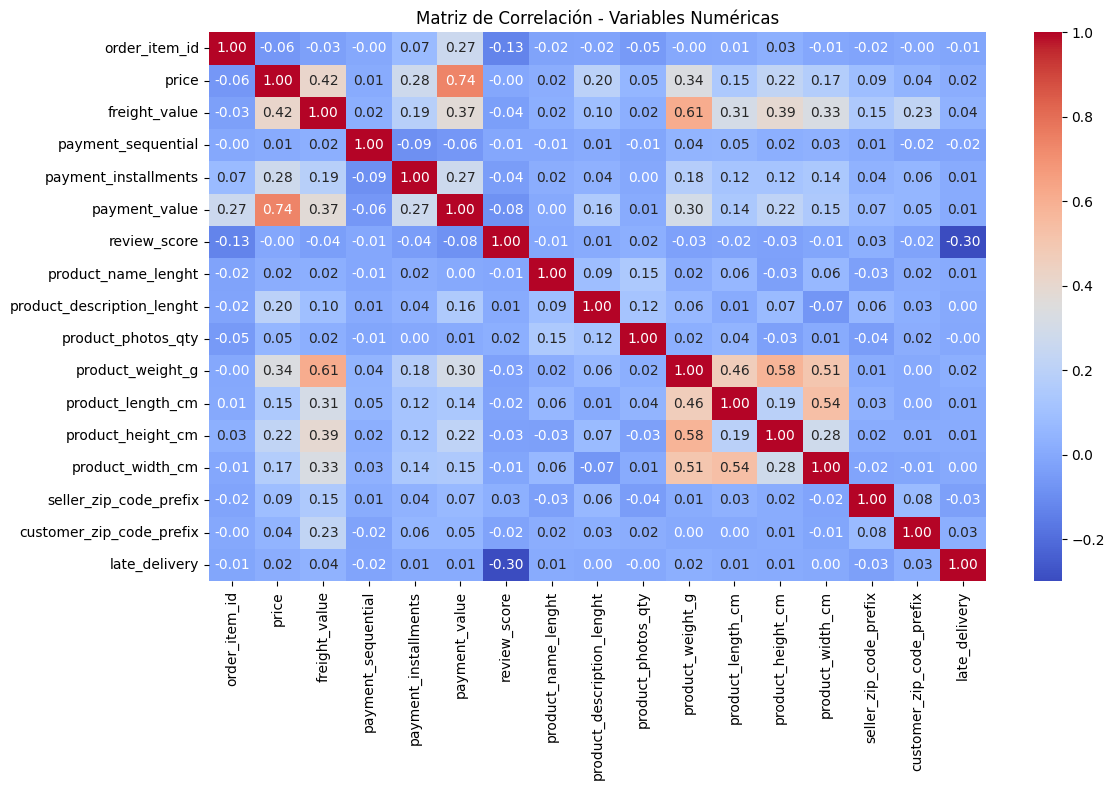

In [21]:
correlacion = final_dataset.corr(numeric_only=True)

# Generar el heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación - Variables Numéricas')
plt.tight_layout()
plt.show()

MIRAMOS CUALES VARIABLES POSEEN MAS DE 0.5 EN LA MATRIZ DE CORRELACION PARA ELIMINARLAS PUES SABEMOS QUE VARIABLES ALTAMENTE CORRELACIONADAS PUEDEN SESGAR EL MODELO

In [22]:
correlacion_late = correlacion['late_delivery'].drop('late_delivery').sort_values(ascending=False)
correlacion_late_df = correlacion_late.to_frame(name='Correlación con late_delivery')

# Identificar pares altamente correlacionados entre sí (correlación > 0.5)
correlacion_upper = correlacion.where(np.triu(np.ones(correlacion.shape), k=1).astype(bool))
pares_alta_correlacion = correlacion_upper.stack().reset_index()
pares_alta_correlacion.columns = ['Variable 1', 'Variable 2', 'Correlación']
pares_alta_correlacion = pares_alta_correlacion[pares_alta_correlacion['Correlación'].abs() > 0.5]

print(pares_alta_correlacion)

            Variable 1         Variable 2  Correlación
19               price      payment_value     0.739236
38       freight_value   product_weight_g     0.611587
116   product_weight_g  product_height_cm     0.581970
117   product_weight_g   product_width_cm     0.506897
122  product_length_cm   product_width_cm     0.535370


VAMOS A CREAR UNA COPIA DEL DATASET Y VAMOS A ELIMINAR UNA DE LAS VARIABLES ALTAMENTE CORRELACIONADAS

In [23]:
# Crear una copia del dataset original
dataset_filtrado = final_dataset.copy()

# Calcular matriz de correlación solo con variables numéricas
correlacion_numerica = dataset_filtrado.corr(numeric_only=True)

# Obtener matriz triangular superior (sin la diagonal)
matriz_superior = correlacion_numerica.where(np.triu(np.ones(correlacion_numerica.shape), k=1).astype(bool))

# Identificar columnas con alta correlación (umbral configurable)
umbral_correlacion = 0.5
variables_a_eliminar = [
    columna
    for columna in matriz_superior.columns
    if any(matriz_superior[columna].abs() > umbral_correlacion)
]

# Eliminar columnas altamente correlacionadas
dataset_filtrado.drop(columns=variables_a_eliminar, inplace=True)

# Verificar columnas resultantes
print("Variables eliminadas por alta correlación:", variables_a_eliminar)
print("Variables restantes:", dataset_filtrado.columns.tolist())

Variables eliminadas por alta correlación: ['payment_value', 'product_weight_g', 'product_height_cm', 'product_width_cm']
Variables restantes: ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value', 'payment_sequential', 'payment_type', 'payment_installments', 'review_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_length_cm', 'seller_zip_code_prefix', 'seller_city', 'seller_state', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state', 'late_delivery']


AMOS A CRERA BOXPLOTS PARA VER EL COMPORTAMIENTO DE LAS VARIABLES NUMERICAS 

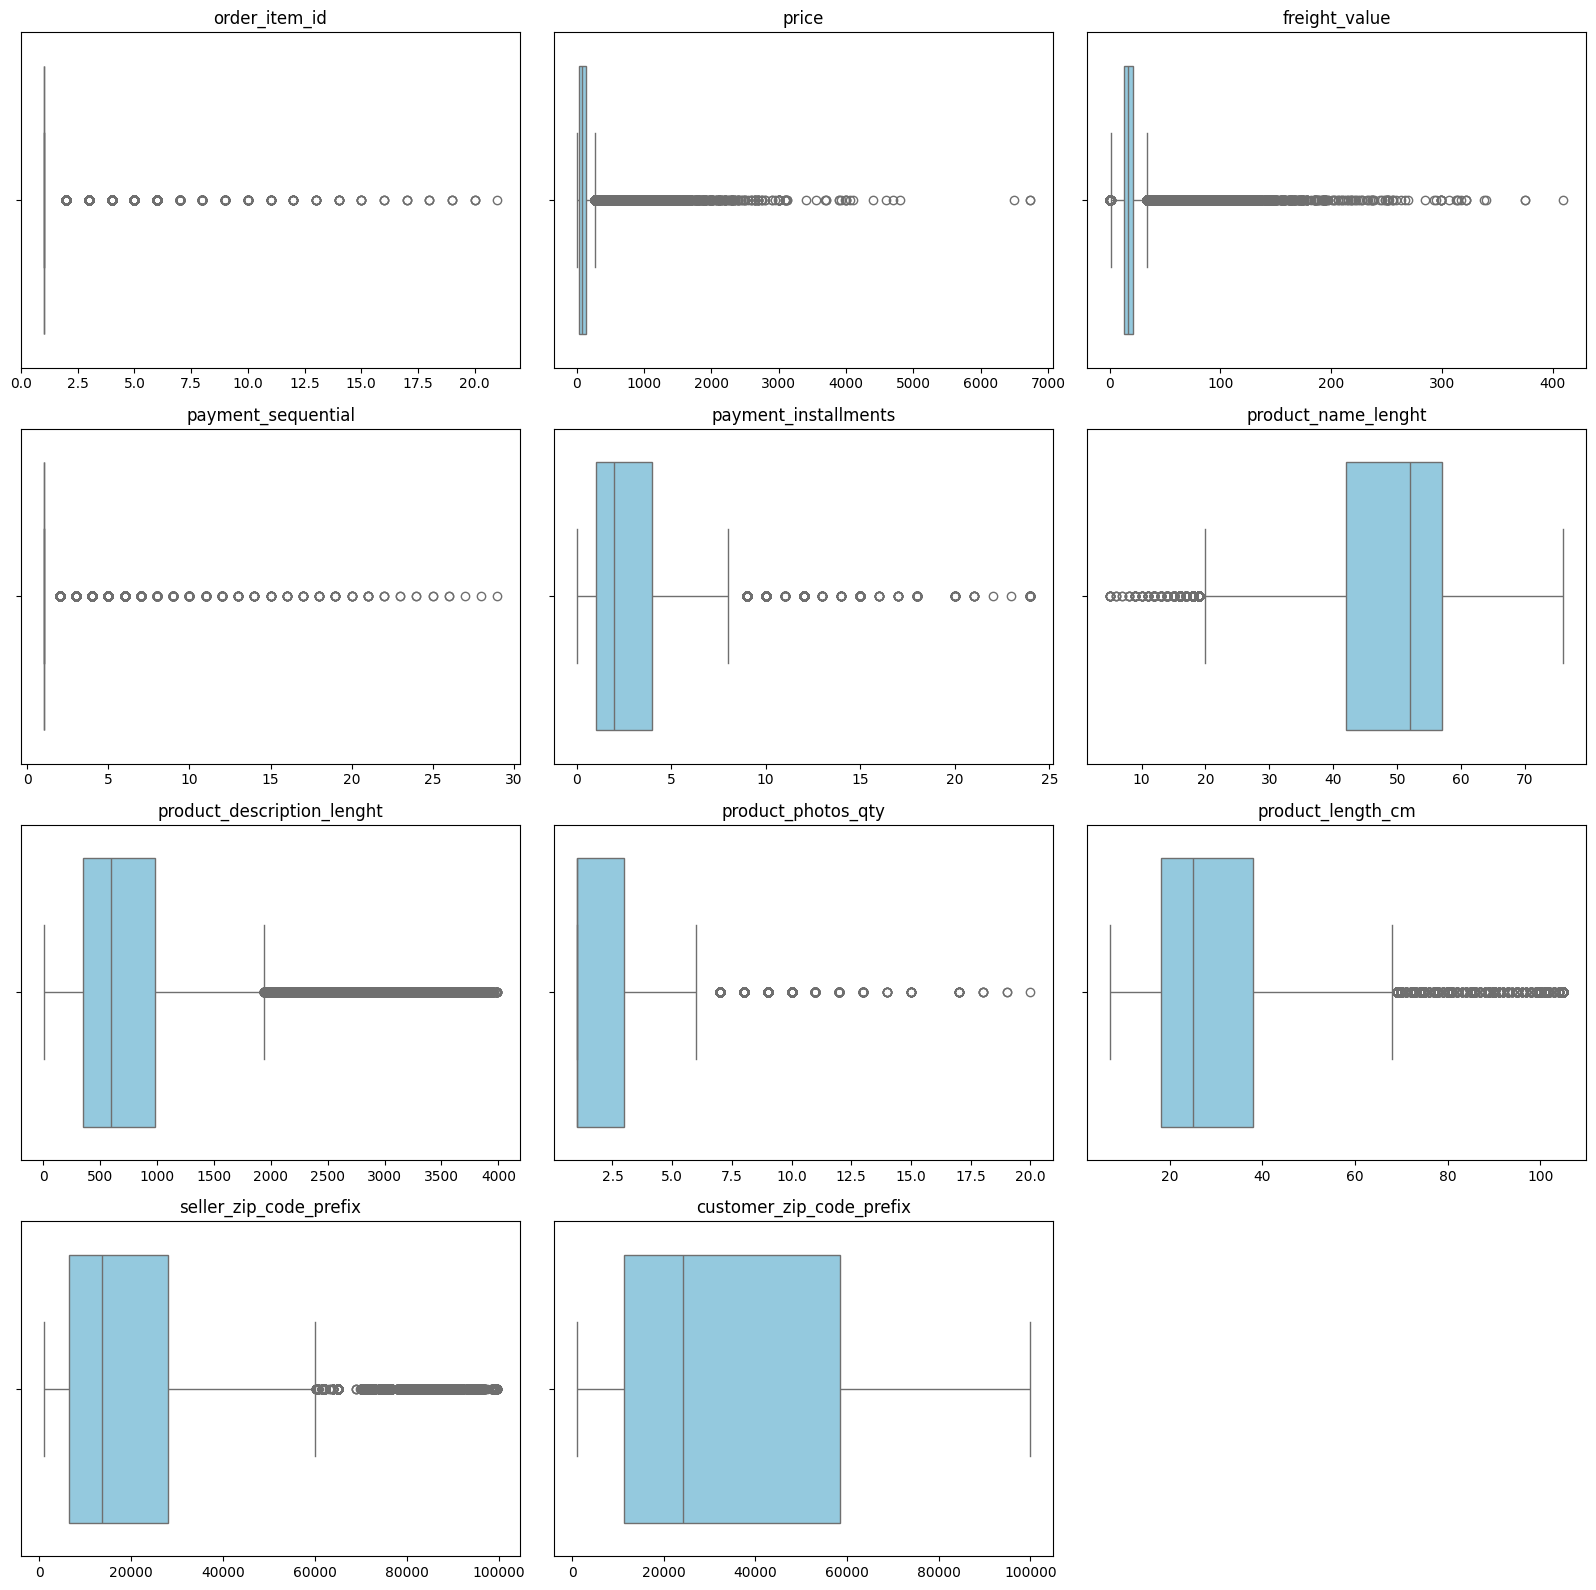

In [24]:


# Seleccionar solo variables numéricas (excepto la variable objetivo)
columnas_numericas = dataset_filtrado.select_dtypes(include=['int64', 'float64']).columns.tolist()
columnas_numericas = [
    col for col in columnas_numericas
    if dataset_filtrado[col].nunique() > 5 and col != 'late_delivery'
]

# Configurar dimensiones de la figura
n = len(columnas_numericas)
ncols = 3
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4 * nrows))
axes = axes.flatten()

# Crear un boxplot por variable
for ax, col in zip(axes, columnas_numericas):
    sns.boxplot(x=dataset_filtrado[col], ax=ax, orient='h', color='skyblue')
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('')

# Eliminar subplots vacíos
for ax in axes[n:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

AHORA MIREMOS UNA DESCRIPCION DEL DATASET FILTRADO

In [25]:
dataset_filtrado.describe(include='all')


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_photos_qty,product_length_cm,seller_zip_code_prefix,seller_city,seller_state,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,late_delivery
count,119143,119143,119143,119143,118966,117057,115722,119143,118310.000000,118310,...,116601.000000,118290.000000,118310.000000,118310,118310,119143,119143.000000,119143,119143,119143.000000
unique,99441,99441,8,98875,90733,81018,NaN,NaN,NaN,32951,...,NaN,NaN,NaN,611,23,96096,NaN,4119,27,NaN
top,895ab968e7bb0d5659d16cd74cd1650c,270c23a11d024a44c896d1894b261a83,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,NaN,NaN,NaN,aca2eb7d00ea1a7b8ebd4e68314663af,...,NaN,NaN,NaN,sao paulo,SP,9a736b248f67d166d2fbb006bcb877c3,NaN,sao paulo,SP,NaN
freq,63,63,115723,63,63,63,NaN,NaN,NaN,536,...,NaN,NaN,NaN,29293,84377,75,NaN,18875,50265,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-12 20:55:38.199616,2018-01-22 15:21:10.241642240,1.196543,NaN,...,2.205161,30.265145,24442.410413,NaN,NaN,NaN,35033.451298,NaN,NaN,0.076110
min,NaN,NaN,NaN,NaN,NaN,NaN,2016-10-11 13:46:32,2016-09-30 00:00:00,1.000000,NaN,...,1.000000,7.000000,1001.000000,NaN,NaN,NaN,1003.000000,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,2017-09-22 21:54:31.249999872,2017-10-02 00:00:00,1.000000,NaN,...,1.000000,18.000000,6429.000000,NaN,NaN,NaN,11250.000000,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,2018-02-01 03:17:55,2018-02-14 00:00:00,1.000000,NaN,...,1.000000,25.000000,13660.000000,NaN,NaN,NaN,24240.000000,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,2018-05-15 00:08:31.500000,2018-05-25 00:00:00,1.000000,NaN,...,3.000000,38.000000,27972.000000,NaN,NaN,NaN,58475.000000,NaN,NaN,0.000000
max,NaN,NaN,NaN,NaN,NaN,NaN,2018-10-17 13:22:46,2018-11-12 00:00:00,21.000000,NaN,...,20.000000,105.000000,99730.000000,NaN,NaN,NaN,99990.000000,NaN,NaN,1.000000


AHORA PROCEDEMOS CON LA IMPUTACION DE VALORES FALTANTES UTILIZANDO LA FORMA DE LA DISTRIBUCION QUE TIENEN LAS VARIABLES

In [26]:
# Seleccionamos solo variables numéricas con más de 5 valores distintos (excluyendo la variable target)
variables_numericas = [
    col for col in dataset_filtrado.select_dtypes(include=['float64', 'int64']).columns
    if dataset_filtrado[col].nunique() > 5 and col != 'late_delivery'
]

# Lista donde guardamos qué método usamos por variable
imputacion_log = []

# Imputar valores faltantes según la asimetría
for col in variables_numericas:
    skew_val = dataset_filtrado[col].skew()
    
    if abs(skew_val) > 1:
        # Si la distribución asimétrica entonces usamos la mediana
        dataset_filtrado[col] = dataset_filtrado[col].fillna(dataset_filtrado[col].median())
        metodo = "mediana"
    else:
        # Si la distribución es más simétrica entonces usamos la mediaar media
        dataset_filtrado[col] = dataset_filtrado[col].fillna(dataset_filtrado[col].mean())
        metodo = "media"
    
    imputacion_log.append({
        "variable": col,
        "skew": round(skew_val, 3),
        "método_usado": metodo
    })

# Crear resumen tipo tabla
df_imputacion_resumen = pd.DataFrame(imputacion_log)
print("Resumen de imputación de valores faltantes:")
print(df_imputacion_resumen)

Resumen de imputación de valores faltantes:
                      variable    skew método_usado
0                order_item_id   7.552      mediana
1                        price   7.893      mediana
2                freight_value   5.543      mediana
3           payment_sequential  15.776      mediana
4         payment_installments   1.620      mediana
5          product_name_lenght  -0.905        media
6   product_description_lenght   2.012      mediana
7           product_photos_qty   1.909      mediana
8            product_length_cm   1.746      mediana
9       seller_zip_code_prefix   1.556      mediana
10    customer_zip_code_prefix   0.785        media


AHORA TRATAREMOS LOS VALORES FALTANTES CON EL MÉTODO DE WINSORIZACION

In [27]:
variables_numericas  # ya definida anteriormente

# Lista para registrar límites aplicados por variable
winsorization_log = []

# Aplicar winsorización IQR por variable
for col in variables_numericas:
    q1 = dataset_filtrado[col].quantile(0.25)
    q3 = dataset_filtrado[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    # Aplicar límites: valores < lower se reemplazan por lower, y valores > upper por upper
    dataset_filtrado[col] = np.where(dataset_filtrado[col] < lower, lower, dataset_filtrado[col])
    dataset_filtrado[col] = np.where(dataset_filtrado[col] > upper, upper, dataset_filtrado[col])

    # Guardar los límites usados
    winsorization_log.append({
        "variable": col,
        "extremo": "inferior",
        "limite_usado": round(lower, 3)
    })
    winsorization_log.append({
        "variable": col,
        "extremo": "superior",
        "limite_usado": round(upper, 3)
    })

# Crear resumen en DataFrame
df_winsor_resumen = pd.DataFrame(winsorization_log)

# Mostrar resumen de winsorización
print("Resumen de tratamiento de outliers (Winsorización):")
print(df_winsor_resumen)

Resumen de tratamiento de outliers (Winsorización):
                      variable   extremo  limite_usado
0                order_item_id  inferior         1.000
1                order_item_id  superior         1.000
2                        price  inferior       -99.300
3                        price  superior       271.900
4                freight_value  inferior         0.975
5                freight_value  superior        33.255
6           payment_sequential  inferior         1.000
7           payment_sequential  superior         1.000
8         payment_installments  inferior        -3.500
9         payment_installments  superior         8.500
10         product_name_lenght  inferior        22.000
11         product_name_lenght  superior        78.000
12  product_description_lenght  inferior      -586.500
13  product_description_lenght  superior      1905.500
14          product_photos_qty  inferior        -2.000
15          product_photos_qty  superior         6.000
16           

OBSERVAMOS QUE LA METODOLOGIA ES UTILIZANDO EL RANGO INTERCUARTILICO, VALORES POR ENCIMA LOS REEMPLAZAMOS POR EL MAXIMO DEL QANTIL 3 Y POR DEBAJO DEL PRIMER CUANTIL

AHORA VAMOS A ESTANDARIZAR EL TEXTO DE LAS VARIABLES 

In [28]:

# Función para quitar tildes
def quitar_tildes(texto):
    if isinstance(texto, str):
        texto = unicodedata.normalize('NFKD', texto)
        texto = ''.join([c for c in texto if not unicodedata.combining(c)])
        return texto
    return texto

# Aplicar a todas las columnas tipo texto
cat_cols = dataset_filtrado.select_dtypes(include='object').columns

for col in cat_cols:
    dataset_filtrado[col] = dataset_filtrado[col].str.strip().str.lower()
    dataset_filtrado[col] = dataset_filtrado[col].apply(quitar_tildes)

dataset_filtrado[cat_cols].drop_duplicates().head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,product_id,seller_id,shipping_limit_date,payment_type,...,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_category_name,seller_city,seller_state,customer_unique_id,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,credit_card,...,NaN,"nao testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,utilidades_domesticas,maua,sp,7c396fd4830fd04220f754e42b4e5bff,sao paulo,sp
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,voucher,...,NaN,"nao testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,utilidades_domesticas,maua,sp,7c396fd4830fd04220f754e42b4e5bff,sao paulo,sp
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,boleto,...,muito boa a loja,muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50,perfumaria,belo horizonte,sp,af07308b275d755c9edb36a90c618231,barreiras,ba
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,credit_card,...,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58,automotivo,guariba,sp,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,go
5,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,credit_card,...,NaN,o produto foi exatamente o que eu esperava e e...,2017-12-03 00:00:00,2017-12-05 19:21:58,pet_shop,belo horizonte,mg,7c142cf63193a1473d2e66489a9ae977,sao goncalo do amarante,rn


In [29]:
# Seleccionar variables numéricas
numeric_cols = dataset_filtrado.select_dtypes(include=['float64', 'int64']).columns

# Lista para guardar los resultados
resumen = []

for col in numeric_cols:
    n_total = dataset_filtrado.shape[0]
    n_missing = dataset_filtrado[col].isnull().sum()

    # Calcular IQR y límites para outliers
    q1 = dataset_filtrado[col].quantile(0.25)
    q3 = dataset_filtrado[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    # Contar outliers
    n_outliers = dataset_filtrado[(dataset_filtrado[col] < lower) | (dataset_filtrado[col] > upper)].shape[0]

    resumen.append({
        "variable": col,
        "missing": n_missing,
        "missing_pct": round(n_missing / n_total * 100, 2),
        "outliers": n_outliers,
        "outliers_pct": round(n_outliers / n_total * 100, 2)
    })

# Crear DataFrame resumen
dataset_filtrado_resumen_missings_outliers = pd.DataFrame(resumen).sort_values(by="missing_pct", ascending=False)
dataset_filtrado_resumen_missings_outliers

,variable,missing,missing_pct,outliers,outliers_pct
5,review_score,997,0.84,19590,16.44
0,order_item_id,0,0.00,0,0.00
1,price,0,0.00,0,0.00
2,freight_value,0,0.00,0,0.00
3,payment_sequential,0,0.00,0,0.00
4,payment_installments,0,0.00,0,0.00
6,product_name_lenght,0,0.00,0,0.00
7,product_description_lenght,0,0.00,0,0.00
8,product_photos_qty,0,0.00,0,0.00
9,product_length_cm,0,0.00,0,0.00


OBSERVAMOS AHORA QUE LIMPIAMOS LAS VARIABLES NO PRESENTAN DATOS FALTANTES NI OUTLIERS, ESTO SIN CONTAR LA DEL REVIEW SCORE QUE NO SERA UTILZADA Y EL LATE DELIVERY QUE ES EL TARGET

AHORA VAMOSA ESCALAR LAS VARIABLES NUMERICAS

In [30]:
# Escalado de variables numéricas, excluyendo order_item_id
numeric_cols = dataset_filtrado.select_dtypes(include=['float64', 'int64']).columns
numeric_cols = [col for col in numeric_cols if col not in ['late_delivery', 'order_item_id']]
scaler = StandardScaler()
dataset_filtrado[numeric_cols] = scaler.fit_transform(dataset_filtrado[numeric_cols])

POSEEMOS VARIAS VARIABLES CATEGORICAS CON UNA CARDINALIDAD MUY ALTA, PARA EJEMPLOS DEL AJUSTE DEL MODELO UNICAMENTE HAREMOS DUMMIES AQUELLAS QUE POSEAN BAJA CARDINALIDAD

In [32]:
# Vamos a generar las dummies solo para columnas categóricas de baja cardinalidad

# Seleccionamos columnas categóricas con pocos valores únicos (por ejemplo, menos de 50)
cat_cols = [
	col for col in dataset_filtrado.select_dtypes(include='object').columns
	if dataset_filtrado[col].nunique() < 50
]

# Aplicamos get_dummies solo a esas columnas
dataset_filtrado = pd.get_dummies(dataset_filtrado, columns=cat_cols, drop_first=True)

AHORA PROCEDEREMOS CON UN PASO COMO LA INGENIERA DE CARACTERISTICAS, COMO ES UN PROYECTO DE ESTUDIO Y NO SE POSEEN LOS CONOCIMIENTOS ESPECIFICOS SOBRE EL AREA, ESTA SECCION SERÁ BÁSICA

In [33]:
dataset_filtrado['dias_diferencia_entrega'] = (
    pd.to_datetime(dataset_filtrado['order_delivered_customer_date']) -
    pd.to_datetime(dataset_filtrado['order_estimated_delivery_date'])
).dt.days

VAMOS A SEPARAR NUESTRAS VARIABLES EN LAS PREDICTORAS Y EN EL TARGET, QUITANDO COLUMNAS DE FECHA, TEXTO Y OTRAS QUE NO SON DESEADAS

In [ ]:
X = dataset_filtrado.drop(columns=[
    'late_delivery', 'customer_id', 'order_id', 'product_id',
    'seller_id', 'shipping_limit_date', 'order_delivered_customer_date', 'order_delivered_carrier_date',
    'order_purchase_timestamp', 'order_approved_at', 'order_estimated_delivery_date',
    'review_comment_title', 'review_comment_message', 'review_answer_timestamp', 'review_creation_date',
    'review_id', 'review_score', 'dias_diferencia_entrega', 'customer_unique_id', 'order_item_id',
    'product_category_name', 'seller_city', 'customer_city'  
])
y = dataset_filtrado['late_delivery']

SELECCION DE VARIABLES 

In [35]:
##CREAMOS UNA COPIA DE LAS COVARIABLES
X_mod = X.copy()
X_mod = X_mod.select_dtypes(exclude=['datetime', 'datetime64[ns]'])

##CREAMOS LA VARIABLE RUIDDO

X_mod['variable_ruido']=np.random.rand(X_mod.shape[0])

##ENTRENAR AL MODELO DEL ARBOL
model=RandomForestClassifier(random_state=44)
model.fit(X_mod,y)

##OBTENEMOS LA SINGIFICANCIA DE LAS VARIABLES
importancia=pd.Series(model.feature_importances_,index=X_mod.columns).sort_values(ascending=False)

##guardamos la importancia del ruido como el umbral
umbral=importancia['variable_ruido']

##SELECIIONAMOS UNIMCANETE LAS VARIABLES CON MAYOR IMPORTANCIA QUE EL RUIDO
variables_importantes=importancia[importancia>umbral]
variables_seleccionadas=variables_importantes.drop(labels='variable_ruido',errors='ignore')

##imprimimos
print(f'Umbral(IMPORTANCIA DE LA VARIABLE ALEATORIA):{umbral:.6f}\n')
print("variablles con umbral mayor al ruido:\n")
print(variables_seleccionadas)

Umbral(IMPORTANCIA DE LA VARIABLE ALEATORIA):0.132022

variablles con umbral mayor al ruido:

customer_zip_code_prefix    0.145775
dtype: float64


OBSERVAMOS QUE CON ESTE METODO DE SELECCION UNICAMENTE CONSIDERAMOS A LA VARIABLE CUSTOMER_ZIP_CODE_PREFIX COMO IMPORTANTE PUES ES LA UNICA QUE TUVO UN UMBRAL MAYOR A LA VARIABLE ALEATORIA, SIN EMBARGO UTILIZAREMOS OTROS MODELOS DE SELECCION DE VARIABLES

SELECCION MEDIANTE EL CRITERIO RFE

In [36]:
##AHORA USANDO EL CRITERIO DE RFE
# Paso 1: Crear una copia de los datos
X_mod = X.copy()

# Paso 2: Eliminar columnas con tipo datetime
fechas = X_mod.select_dtypes(include='datetime').columns
X_mod = X_mod.drop(columns=fechas)

# Paso 3: Aplicar RFE con RandomForest
modelo = RandomForestClassifier(random_state=44)
selector = RFE(estimator=modelo, n_features_to_select=10,)
selector.fit(X_mod, y)

# Paso 4: Obtener variables seleccionadas
rfe_features = X_mod.columns[selector.support_]
print('Variables seleccionadas por RFE:\n')
print(rfe_features.tolist())

Variables seleccionadas por RFE:

['price', 'freight_value', 'payment_installments', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_length_cm', 'seller_zip_code_prefix', 'customer_zip_code_prefix', 'payment_type_credit_card']


CON ESTE CRITERIO SE SELECCIONAN LA CANTIDAD DE VARIABLES A UTILIZAR, SIN EMBARGO UTILIZAREMOS OTRO CRITERIO DONDE BUSCAMOS LA VARIABLES QUE NOS MAXIMICEN LA METRICA DEL F1

Número óptimo de features: 2
Variables seleccionadas: ['product_description_lenght', 'customer_zip_code_prefix']


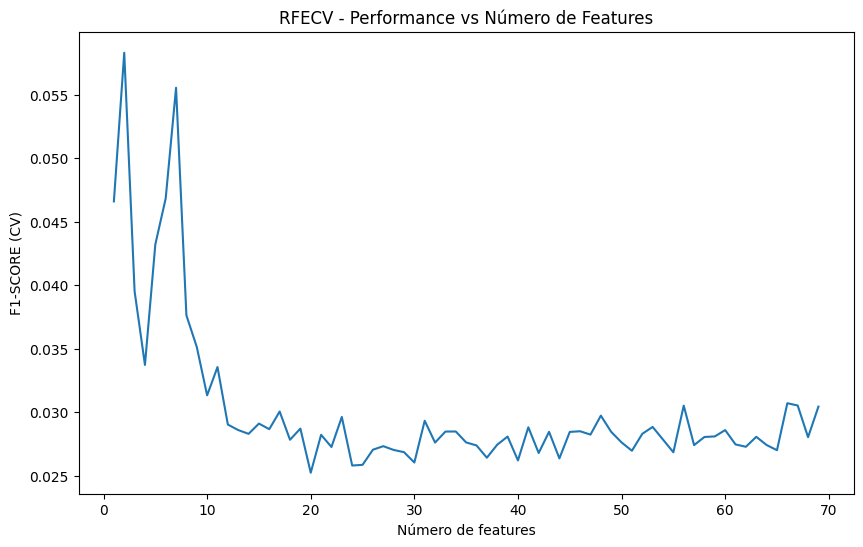

In [37]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

X_mod = X.copy()

# Paso 2: Codificar variables categóricas (si existen)


# Paso 3: Configurar RFECV con RandomForest
modelo = RandomForestClassifier(random_state=44, n_jobs=-1)  # Paralelizar usar todos los nucleos para aumentar velocidad
cv = StratifiedKFold(n_splits=5)  # Validación cruzada estratificada
selector = RFECV(
    estimator=modelo,
    cv=cv,
    scoring='f1',  # Puede ser 'f1', 'roc_auc', etc.
    min_features_to_select=1,  # Mínimo de features a considerar
    step=1  # Features eliminadas en cada iteración
)
selector.fit(X_mod, y)

# Paso 4: Resultados
print(f"Número óptimo de features: {selector.n_features_}")
print("Variables seleccionadas:", X_mod.columns[selector.support_].tolist())

# Gráfico de performance vs número de features 
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(selector.cv_results_['mean_test_score']) + 1), selector.cv_results_['mean_test_score'])
plt.xlabel("Número de features")
plt.ylabel("F1-SCORE (CV)")
plt.title("RFECV - Performance vs Número de Features")
plt.show()

OBSERVAMOS QUE NO SE OBTIENE UN BUEN F1-SCORE, ESTO PUEDE SER POR EL HECHO DE CONTAR UN TARGET EL CUAL POSEE CLASES DESBALANCEADAS, SIN EMBARGO PARA LA CONTINUACIÓN SE UTILIZARÁN LAS 10 VARIABLES SELECCIONADAS MEDIANTE EL RFE

In [38]:
vas=['price', 'freight_value', 'payment_installments', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_length_cm', 'seller_zip_code_prefix', 'customer_zip_code_prefix', 'payment_type_credit_card']

df_ff= dataset_filtrado[vas + ['late_delivery']].copy()

AHORA VOLVAMOS A EVALUAR LA CORRELACION PARA LAS VARIABLES SELECCIONADAS 

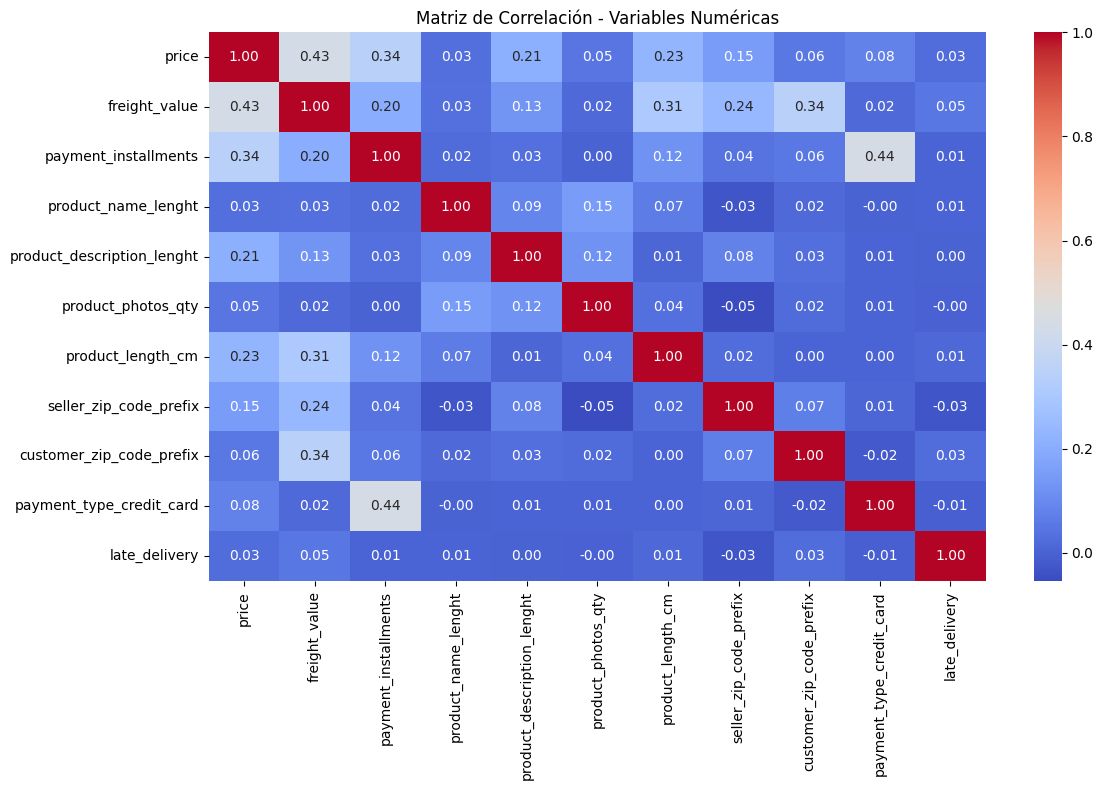

In [39]:

# Calcular la matriz de correlación solo con variables numéricas
correlacion = df_ff.corr(numeric_only=True)

# Generar el heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación - Variables Numéricas')
plt.tight_layout()
plt.show()

OBSEVERVAMOS QUE NO HAY VARAIBLES QUE POSEAN UNA CORRELACION MAYOR A 0.5 POR LO QUE NO SE ELIMINARA NINGUNA.

AHORA SE PROCEDERA CON LOS AJUSTES DE DIFERENTES MODELOS Y LA COMPARACIÓN DE LOS MISMOS.

SEPARAMOS LAS VARIABLES Y EL TARGET

In [43]:
df= df_ff.copy()

target=df['late_delivery']
X = df.drop(columns=['late_delivery'])
y=target


y.value_counts()

late_delivery
0    110075
1      9068
Name: count, dtype: int64

DIVIDIMOS LOS DATOS EN TRAIN Y OOT

In [44]:

##DIVISION DE LOS DATOS PARA TRAIN/OOT
X_train, X_oot, y_train, y_oot = train_test_split(
    X, y, test_size=0.2, random_state=44, stratify=y
)

X_train.shape, X_oot.shape

((95314, 10), (23829, 10))

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=44, stratify=y_train)
X_train.shape, X_oot.shape

((76251, 10), (23829, 10))

IMPORTAMOS LOS MODELOS DE CLASIFICACIÓN Y EMPEZAREMOS A TRABAJAR CON ELLOS.

In [46]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier  
from imblearn.ensemble import BalancedRandomForestClassifier

VAMOS A EVALUAR TODOS LOS MODELOS COMO PRIMERA INSTANCIA PARA COMPRARA LOS RESULTADOS QUE NOS DAN 

In [47]:
models = {
    "RandomForest": RandomForestClassifier(random_state=44),
    "DecisionTree": DecisionTreeClassifier(random_state=44),
    "GradientBoosting": GradientBoostingClassifier(random_state=44),
    "LightGBM": LGBMClassifier(random_state=44),
    "CatBoost": CatBoostClassifier(random_state=44, verbose=False),
    "BalancedRandomForest": BalancedRandomForestClassifier(random_state=44)
}

for name, model in models.items():
    print(f"\nEntrenando y evaluando: {name}..." )
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print("Matriz de confusión:")
    print(confusion_matrix(y_test, y_pred) )



Entrenando y evaluando: RandomForest...
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     17612
           1       0.76      0.16      0.26      1451

    accuracy                           0.93     19063
   macro avg       0.85      0.58      0.61     19063
weighted avg       0.92      0.93      0.91     19063

Matriz de confusión:
[[17542    70]
 [ 1224   227]]

Entrenando y evaluando: DecisionTree...
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     17612
           1       0.23      0.27      0.25      1451

    accuracy                           0.87     19063
   macro avg       0.58      0.60      0.59     19063
weighted avg       0.89      0.87      0.88     19063

Matriz de confusión:
[[16282  1330]
 [ 1053   398]]

Entrenando y evaluando: GradientBoosting...
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     17612
      

USANDO COMO METRICA OBJETIVO EL F1-SCORE EL QUE MEJOR SE COMPORTA ES EL BALANCEDRANDOMFOREST, ALGO QUE ES ESPERABLE PUES TIENE EN CUENTA EL DESBALANCE DE LAS CLASES, SIN EMBARGO QUISIERAMOS MEJORAR ESTO PUES NO ES UN GRAN RENDIMIENTO.

TUNNING DE HIPERPARAMETROS CON LOS 3 MODELOS QUE MEJOR RENDIMIENTO DIERON USANDO ESTRATIFICAION CRUZADA.

In [53]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

##PARA EL RANDOMFOREST
param_grid = {
    'n_estimators': [200, 500],
    'max_depth': [ 5, 10, 500],
    'min_samples_split': [5, 3],
}

cv=StratifiedKFold(5) ###VALIDACION CRUZADA donde 5 es el numero de folds 
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=44), param_grid, cv=cv, scoring='f1', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
print("Mejores hiperparámetros para RandomForest:", grid_search_rf.best_params_)
print("Mejor puntuación F1 para RandomForest:", grid_search_rf.best_score_)

Mejores hiperparámetros para RandomForest: {'max_depth': 500, 'min_samples_split': 3, 'n_estimators': 500}
Mejor puntuación F1 para RandomForest: 0.2247268812944107


In [54]:
##PARA EL DECISION TREE
param_grid_dt = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [5, 30],
    'min_samples_leaf': [5, 20]
}
cv=StratifiedKFold(n_splits=5)
grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=44), param_grid_dt, cv=cv, scoring='f1', n_jobs=-1)
grid_search_dt.fit(X_train, y_train)
print("Mejores hiperparámetros para DecisionTree:", grid_search_dt.best_params_)
print("Mejor puntuación F1 para DecisionTree:", grid_search_dt.best_score_)

Mejores hiperparámetros para DecisionTree: {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5}
Mejor puntuación F1 para DecisionTree: 0.17545813598096677


In [55]:
###BALANCED RANDOM FOREST
from imblearn.ensemble import BalancedRandomForestClassifier
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
param_grid_brf = {
    "n_estimators": [300, 600],
    "max_depth": [None, 20],
    "min_samples_split": [2, 10],
    "min_samples_leaf": [1, 5],
    "max_features": ["sqrt"],          # fijo para reducir combinaciones
    "sampling_strategy": ['auto'],      # fijo para reducir combinaciones
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=44)

grid_search_brf = GridSearchCV(
    estimator=BalancedRandomForestClassifier(random_state=44, verbose=False, n_jobs=-1),
    param_grid=param_grid_brf,
    cv=cv,
    scoring='f1',          # usa 'f1_weighted' si fuera multiclase
    n_jobs=-1,
    verbose=1
)

grid_search_brf.fit(X_train, y_train)

print("Mejores hiperparámetros para BalancedRandomForest:", grid_search_brf.best_params_)
print("Mejor puntuación F1 para BalancedRandomForest:", grid_search_brf.best_score_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/Users/gallego/proyectos/modelo_clasificacion/.venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejores hiperparámetros para BalancedRandomForest: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 600, 'sampling_strategy': 'auto'}
Mejor puntuación F1 para BalancedRandomForest: 0.22369090244834097


AHORA APLIQUEMOS LAS TECNICAS DE REMUESTRO  CON ESTAS FUNCIONES MIRAMOS EL DESBALANCEO, APLICAMOS LA TECNICA DE SMOTEEN PARA BALANCEAR Y SE AJUSTA EL MODELO YA BALANCEADO UNICAMENTE EN TRAIN, PARA TEST Y OOT DEBE SEGUIR SIN BALANCEAR 

In [56]:
from collections    import Counter
from typing import Any, Tuple, List, Dict
import numpy as np
from imblearn.combine import SMOTEENN, SMOTETomek 

def descrbie_counts(y, title="str")-> None:
    counts = Counter(y)
    total = sum(counts.values())
    if title:
        print(title)
    print({k: f"{v} ({v/total:.2%})" for k, v in counts.items()})

def train_rf_conremuestreo(
        X_train,
        y_train,
        X_test,
        y_test,
        X_oot,
        y_oot,
        sampler_dict: Dict[str, Any],
        random_state: int = 42
) -> Dict[str, Dict[str, Any]]:
    "Entrena y evalúa un modelo DecisionTree con remuestreo y devuelve los resultados. "
    results: Dict[str, Dict[str, Any]] = {}

    y_train_arr = np.asarray(y_train)
    y_test_arr = np.asarray(y_test)
    y_oot_arr = np.asarray(y_oot)

    print("\nDistribución original train/test/oot:")
    descrbie_counts(y_train_arr, "Train")
    descrbie_counts(y_test_arr, "Test") 
    descrbie_counts(y_oot_arr, "OOT")

    for name, sampler in sampler_dict.items():
        print("\n"+ "="*100)
        print(f'Método de balanceo: {name}')\
        
        ##1 conteoo antes de balancear (solo train)
        
        train_counts = Counter(y_train_arr)
        print("Distribución antes de balancear (train):", train_counts)

        ##2 remuestreo solo en train
        if sampler is None:
            X_bal, y_bal = X_train, y_train_arr

        else:
            X_bal, y_bal = sampler.fit_resample(X_train, y_train_arr)

        res_counts = Counter(y_bal)
        print("Distribución después de balancear (train):", dict(res_counts))

        ##3 Entreno Radomtree

        clf= DecisionTreeClassifier(random_state=44, max_depth=None, min_samples_leaf=5, min_samples_split=5)
        clf.fit(X_bal, y_bal)

        ##EVLUACION TEST Y OOT

        y_pre_train=clf.predict(X_bal)
        y_pre_test=clf.predict(X_test)
        y_pre_oot=clf.predict(X_oot)


        report_train=classification_report(y_bal, y_pre_train, digits=4)
        report_test=classification_report(y_test_arr, y_pre_test, digits=4)
        report_oot=classification_report(y_oot_arr, y_pre_oot, digits=4)

        print("\nReporte de clasificación - Train:")
        print(report_train)
        print("Reporte de clasificación - Test:")
        print(report_test)
        print("Reporte de clasificación - OOT:")
        print(report_oot)

        results[name] = {
            "y_train_counts": dict(train_counts),
            "y_res_counts": dict(res_counts),
            "report_test": report_test,
            "report_oot": report_oot,
            "model": clf # type: ignore
        }

    return results

MIREMOS EL REMUESTREO COMO BALANCEA LAS CLASES CON EL MODELO DEL DECISION TREE

In [ ]:
##DEFINIMOS EL DICCIONARIO DE REMUESTREO
samplers={
    "Sin remuestreo": None,
    "SMOTEENN": SMOTEENN(random_state=44),
}
resultados = train_rf_conremuestreo(X_train, y_train, X_test, y_test, X_oot, y_oot, samplers)


Distribución original train/test/oot:
Train
{np.int64(0): '70448 (92.39%)', np.int64(1): '5803 (7.61%)'}
Test
{np.int64(0): '17612 (92.39%)', np.int64(1): '1451 (7.61%)'}
OOT
{np.int64(1): '1814 (7.61%)', np.int64(0): '22015 (92.39%)'}

Método de balanceo: Sin remuestreo
Distribución antes de balancear (train): Counter({np.int64(0): 70448, np.int64(1): 5803})
Distribución después de balancear (train): {np.int64(0): 70448, np.int64(1): 5803}

Reporte de clasificación - Train:
              precision    recall  f1-score   support

           0     0.9565    0.9856    0.9708     70448
           1     0.7229    0.4558    0.5591      5803

    accuracy                         0.9453     76251
   macro avg     0.8397    0.7207    0.7650     76251
weighted avg     0.9387    0.9453    0.9395     76251

Reporte de clasificación - Test:
              precision    recall  f1-score   support

           0     0.9330    0.9589    0.9458     17612
           1     0.2482    0.1647    0.1980      1

MIREMOS EL BALANCED RANDOMFOREST SIN EL REMUESTREO PUES ESTE YA TIENE EN CUENTA LAS CLASES DESBALANCEADAS.

In [ ]:
def train_balanced_rf(
        X_train, y_train,
        X_test, y_test,
        X_oot, y_oot,
        random_state: int = 42
) -> Dict[str, Any]:
    print("\n" + "="*100)
    print("Modelo: BalancedRandomForest (sin remuestreo externo)")

    clf = BalancedRandomForestClassifier(
        n_estimators=600,
        max_depth=None,
        max_features='sqrt',
        min_samples_leaf=1,
        min_samples_split=3,
        sampling_strategy='auto',   # balance 1:1 por árbol
        n_jobs=-1,
    )
    clf.fit(X_train, y_train)

    y_pre_train = clf.predict(X_train)  # evalúa sobre el train original
    y_pre_test  = clf.predict(X_test)
    y_pre_oot   = clf.predict(X_oot)

    report_train = classification_report(y_train, y_pre_train, digits=4)
    report_test  = classification_report(y_test,  y_pre_test,  digits=4)
    report_oot   = classification_report(y_oot,  y_pre_oot,   digits=4)

    print("\nReporte de clasificación - Train:")
    print(report_train)
    print("Reporte de clasificación - Test:")
    print(report_test)
    print("Reporte de clasificación - OOT:")
    print(report_oot)

    return {
        "report_train": report_train,
        "report_test":  report_test,
        "report_oot":   report_oot,
        "model":        clf
    }


resultado_brf = train_balanced_rf(
    X_train, y_train, X_test, y_test, X_oot, y_oot, random_state=44
)


Modelo: BalancedRandomForest (sin remuestreo externo)

Reporte de clasificación - Train:
              precision    recall  f1-score   support

           0     1.0000    0.7557    0.8608     70448
           1     0.2521    1.0000    0.4027      5803

    accuracy                         0.7743     76251
   macro avg     0.6261    0.8778    0.6318     76251
weighted avg     0.9431    0.7743    0.8260     76251

Reporte de clasificación - Test:
              precision    recall  f1-score   support

           0     0.9594    0.6768    0.7936     17612
           1     0.1425    0.6520    0.2339      1451

    accuracy                         0.6749     19063
   macro avg     0.5509    0.6644    0.5138     19063
weighted avg     0.8972    0.6749    0.7510     19063

Reporte de clasificación - OOT:
              precision    recall  f1-score   support

           0     0.9572    0.6712    0.7891     22015
           1     0.1374    0.6356    0.2260      1814

    accuracy               

EL DESBALANCE DE CLASES ES ALGO QUE AFECTA AL MODELO EN GRAN FORMA, CUANDO NINGUNO DE LOS MODELOS LOGRA AJUSTARSE DE LA MEJOR FORMA Y NO SE TIENE MAS INFOMRACIÓN SE PUEDEN APLICAR OTROS MÉTODOS O APLICAR UN TRADE-OFF ENTRE LAS METRICAS PARA VER CUAL DE ELLS ES LA MAS IMPORTANTE, SI LA IMPORTANTE FUERA EL RECALL EL MODELO DEL BALANCED RANDOM FOREST ES LA QUE MEJOR SE COMPORTA FUERA DEL TRAIN SIN EMBARGO SERIA RECOMENDABLE TENER UN MEJORE RENDIMIENTO.